This notebook prompts all 4 of @gfodor's pixelart loras in parallel. (It is similar to the previous two notebooks.)

In [1]:
import torch
from diffusers import AutoPipelineForText2Image
from concurrent.futures import ProcessPoolExecutor, as_completed

def init_pipe(model_id, adapter_id, gpu_index):
    print(f"Initializing {model_id} with {adapter_id} on GPU {gpu_index}.\n")
    pipe = AutoPipelineForText2Image.from_pretrained(model_id)
    pipe.to(f"cuda:{gpu_index}")
    pipe.load_lora_weights(adapter_id)
    pipe.fuse_lora()
    return pipe

def generate_image(pipe, prompt):
    return pipe(prompt=prompt, num_inference_steps=60, guidance_scale=5).images[0]

init_args = [
    # model_id, adapter_id, gpu_index
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-flat-256x256", 0),
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-detailed-256x256", 1),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-detailed-256x256", 2),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-flat-256x256", 3),
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-flat-256x256", 4),
    ("segmind/SSD-1B", "gfodor/bigp1xart-ssd-1b-detailed-256x256", 5),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-detailed-256x256", 6),
    ("segmind/Segmind-Vega", "gfodor/bigp1xart-vega-flat-256x256", 7),
]

pipes = []
with ProcessPoolExecutor() as executor:
    future_pipes = [executor.submit(init_pipe, *args) for args in init_args]
    for future in as_completed(future_pipes):
        pipes.append(future.result())

Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-detailed-256x256 on GPU 1.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-detailed-256x256 on GPU 2.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-flat-256x256 on GPU 3.
Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-flat-256x256 on GPU 4.
Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-detailed-256x256 on GPU 5.
Initializing segmind/SSD-1B with gfodor/bigp1xart-ssd-1b-flat-256x256 on GPU 0.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-detailed-256x256 on GPU 6.
Initializing segmind/Segmind-Vega with gfodor/bigp1xart-vega-flat-256x256 on GPU 7.










Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed down. We assume it will never going to be the case, but if it is, please file but to https://github.com/pytorch/pytorch
[W CudaIPCTypes.cpp:95] Producer process tried to deallocate over 1000 memory blocks referred by consumer processes. Deallocation might be significantly slowed 

In [2]:
print(len(pipes))

8


In [23]:
import os
import re

def get_next_filename(directory):
    # Regular expression to match the pattern 'image####.png'
    pattern = re.compile(r'image(\d{4})\.png')

    # Get the list of files in the directory
    files = os.listdir(directory)

    # Find the highest number in the filenames
    max_number = 0
    for file in files:
        match = pattern.match(file)
        if match:
            number = int(match.group(1))
            max_number = max(max_number, number)

    # Construct the next filename with incremented number
    next_number = max_number + 1
    return f'image{next_number:04d}.png'



In [30]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# Function to generate images within threads
def generate_image_thread(pipe, prompt):
    return pipe(prompt=prompt, num_inference_steps=60, guidance_scale=5).images[0]

# Now, use the pipes for image generation with threads
prompt = "bigp1xart A cute fuzzy purple monster. Cuddly. Adorable. Plush. Comfortable."

with ThreadPoolExecutor() as executor:
    futures = [executor.submit(generate_image_thread, pipe, prompt) for pipe in pipes]
    images = [future.result() for future in as_completed(futures)]

# Ensure the ~/images directory exists
os.makedirs(os.path.expanduser('~/images'), exist_ok=True)
directory = os.path.expanduser('~/images')

# Save each image
for i, image in enumerate(images, start=1):
    filename = get_next_filename(directory)
    image.save(f"{directory}/{filename}")
    print(filename)


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

image0025.png
image0026.png
image0027.png
image0028.png
image0029.png
image0030.png
image0031.png
image0032.png


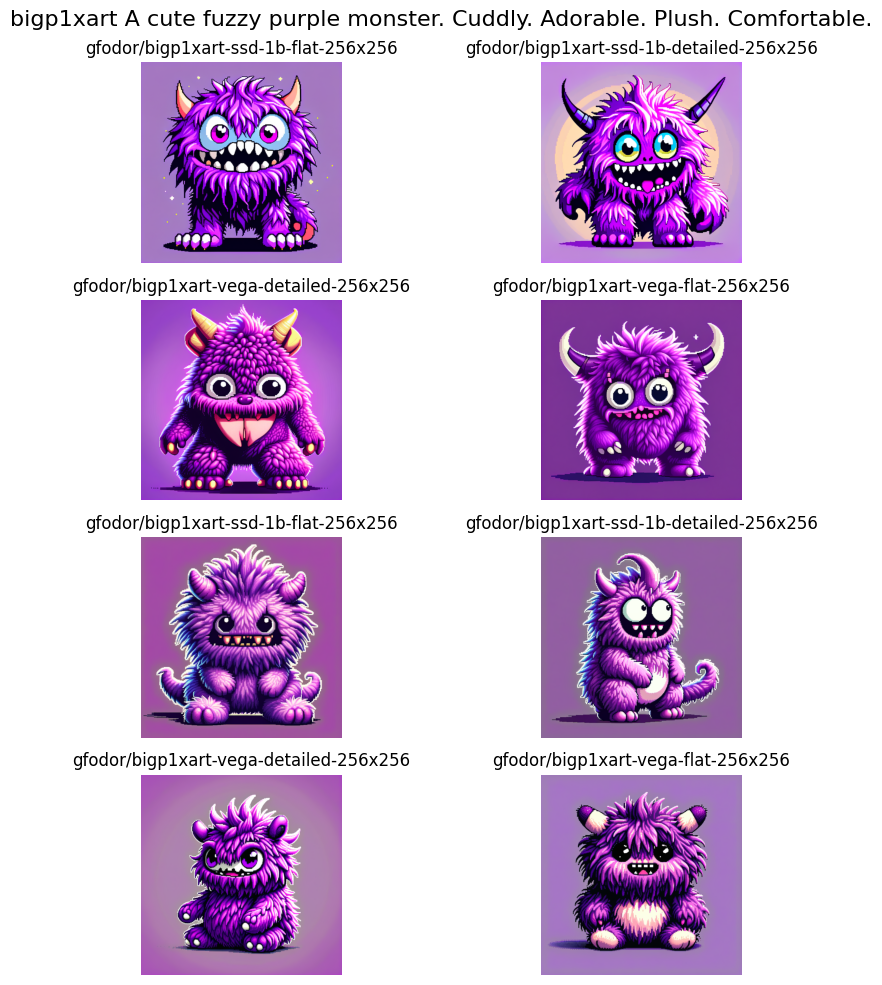

In [31]:
import matplotlib.pyplot as plt

# Assuming 'images' is a list of PIL Image objects and corresponds to the order in 'init_args'
fig, axs = plt.subplots(4, 2, figsize=(10, 10))  # Adjust the figure size as needed
fig.suptitle(prompt, fontsize=16)  # Set the title of the entire figure
axs = axs.flatten()  # Flatten the array of axes for easy iteration

for (model_id, adapter_id, gpu_index), img, ax in zip(init_args, images, axs):
    ax.imshow(img)
    ax.set_title(adapter_id)  # Set the title of each subplot to the adapter_id
    ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()

In [5]:
!nvidia-smi

Mon Dec 25 00:20:26 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  | 00000000:06:00.0 Off |                    0 |
| N/A   43C    P0              63W / 400W |  16879MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--